In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Load the Data

In [83]:
# load the data
df_energy = pd.read_csv('data/df_energy_processed.csv')
df_weather = pd.read_csv('data/df_weather_processed.csv')
df = pd.read_csv('data/df2.csv')

In [84]:
# Convert the column from string to datetime
df['time'] = pd.to_datetime(df['time'], utc=True) # datetime values that are explicitly in UTC

#Set timeframe data for easier accessing
df["year"]= df['time'].dt.year
df["month"]= df['time'].dt.month_name()
df["day"] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.hour

In [85]:
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'city_name',
       'weather_main', 'weather_description', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [86]:
df_original = df.copy()
df.drop(columns=['weather_id', 'time', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'price day ahead'], inplace=True)

In [87]:
pd.set_option('display.max_columns', None) 
print(df.head)

<bound method NDFrame.head of        generation biomass  generation fossil brown coal/lignite  \
0                   449.0                                 328.0   
1                   448.0                                 323.0   
2                   438.0                                 254.0   
3                   428.0                                 187.0   
4                   410.0                                 178.0   
...                   ...                                   ...   
35012               297.0                                   0.0   
35013               296.0                                   0.0   
35014               292.0                                   0.0   
35015               293.0                                   0.0   
35016               290.0                                   0.0   

       generation fossil gas  generation fossil hard coal  \
0                     5196.0                       4755.0   
1                     4857.0               

# Encoding Categorical Data

In [88]:
categorical_columns = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)

In [89]:
categorical_columns

Index(['city_name', 'weather_main', 'weather_description', 'month', 'day'], dtype='object')

In [90]:
df_encoded.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price actual', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'year',
       'hour', 'city_name_Valencia', 'weather_main_clear',
       'weather_main_clouds', 'weather_main_drizzle', 'weather_main_fog',
       'weather_main_mist', 'weather_main_rain', 'weather_main_thunderstorm',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_description_few clouds', 'weather_description_fog',
       '

In [91]:
# Reinsert the target column at the last position
column_to_move = df_encoded.pop('price actual')
df_encoded['price actual'] = column_to_move

In [92]:
X = df_encoded.iloc[:, :-1].values
y = df_encoded.iloc[:, -1].values

- we have a large no. of columns due to encoding.

# Splitting dataset into Training and Test

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [94]:
X.shape

(35017, 77)

In [95]:
X_test.shape

(7004, 77)

# Models

## Linear Regression

In [96]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R-squared:", r2)


RMSE: 9.464825532239919
R-squared: 0.5417404258557769


## Ridge & Lasso

In [57]:
from sklearn.linear_model import Ridge, Lasso

ridge_model = Ridge(alpha=0.05, max_iter=10000)  # You can adjust the alpha (regularization strength) as needed
lasso_model = Lasso(alpha=0.01, max_iter=10000)

ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# predictions
ridge_predictions = ridge_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)

#Evaluate
ridge_rmse = mean_squared_error(y_test, ridge_predictions, squared=False)
lasso_rmse = mean_squared_error(y_test, lasso_predictions, squared=False)
ridge_r2 = r2_score(y_test, ridge_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)


print("Ridge Regression RMSE:", ridge_rmse)
print("Ridge Regression r2:", ridge_r2)

print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression r2:", lasso_r2)

Ridge Regression RMSE: 9.464818323434304
Ridge Regression r2: 0.5417411239146945
Lasso Regression RMSE: 9.470229865175465
Lasso Regression r2: 0.541216951998593


## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)

# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['squared_error'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_regressor = grid_search.best_estimator_

y_pred = best_regressor.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("r2:", r2)

RMSE: 5.985938675390223
r2: 0.8167049030625729


## Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("r2:", r2)

RMSE: 3.9155874210455788
r2: 0.9215703691875315


# Observation

- Out of the traditional ML models that were used, Random Forest Regressor had the lowest RMSE (3.91) & R2 score (0.92).
- The next step would be to explore the Time-Series specific models.

# Plots

In [103]:
num_samples_test = X_test.shape[0]
num_samples_test

7004

In [104]:
df_original['time'].loc[(len(X)-num_samples_test): len(X)].shape

(7004,)

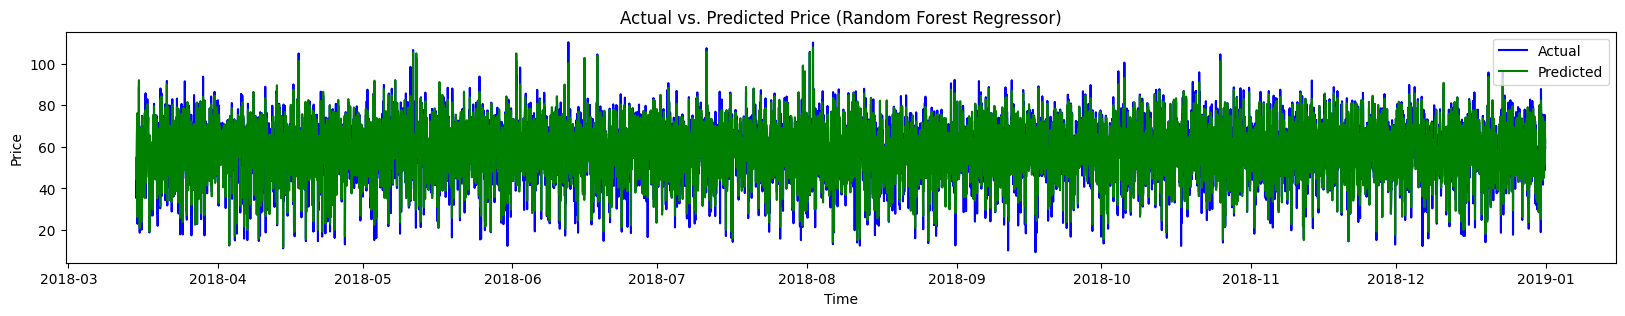

In [105]:
# Random Forest regressor

# Plot the actual values (y_test) and predicted values (y_pred) on the same plot
plt.figure(figsize=(20, 3))
plt.plot(df_original['time'].loc[(len(X)-num_samples_test): len(X)], y_test, label='Actual', color='blue')
plt.plot(df_original['time'].loc[(len(X)-num_samples_test): len(X)], y_pred, label='Predicted', color='green')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Price (Random Forest Regressor)')
plt.legend()

# Show the plot
plt.show()

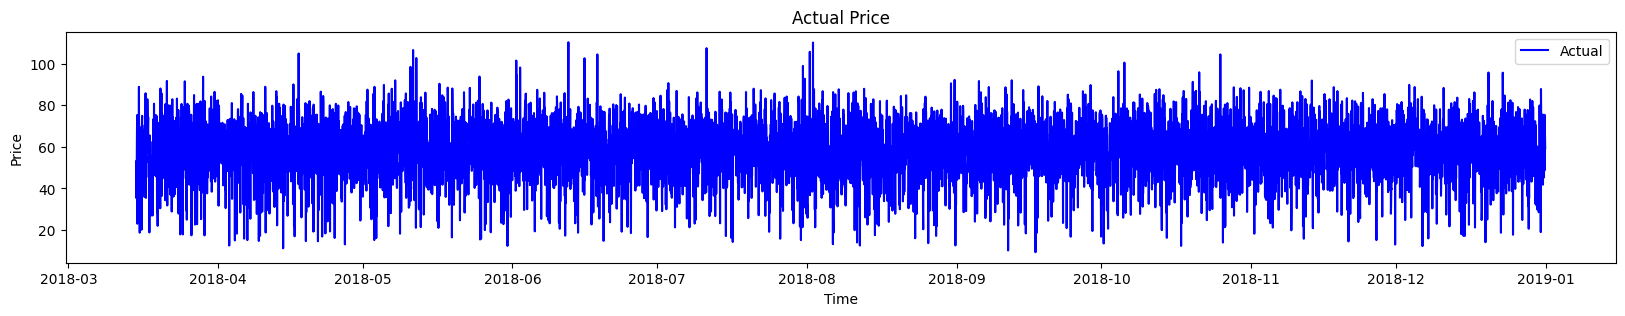

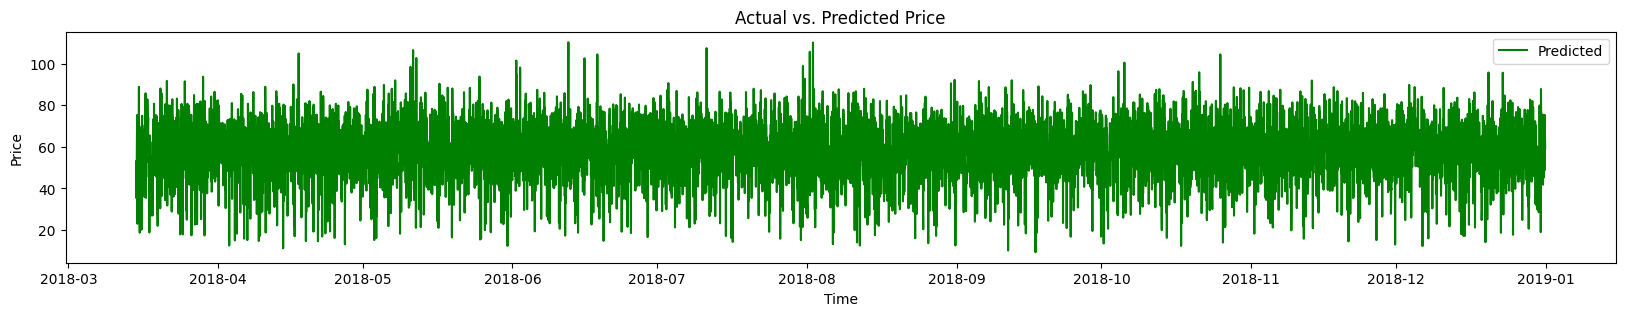

In [106]:
# Plot only the actual values (y_test)
plt.figure(figsize=(20, 3))
plt.plot(df_original['time'].loc[(len(X)-num_samples_test): len(X)], y_test, label='Actual', color='blue')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual Price')
plt.legend()
plt.show()


# Plot only the predicted values (y_pred)
plt.figure(figsize=(20, 3))
plt.plot(df_original['time'].loc[(len(X)-num_samples_test): len(X)], y_test, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Price')
plt.legend()
plt.show()

- Looking at the actual and predicted values which are generated on the data which contained averaged weather variable values for one timestamp, we can see less denser plots than the previous data. However, still we cannot observe any visual difference. Thus, we must rely on the loss values.

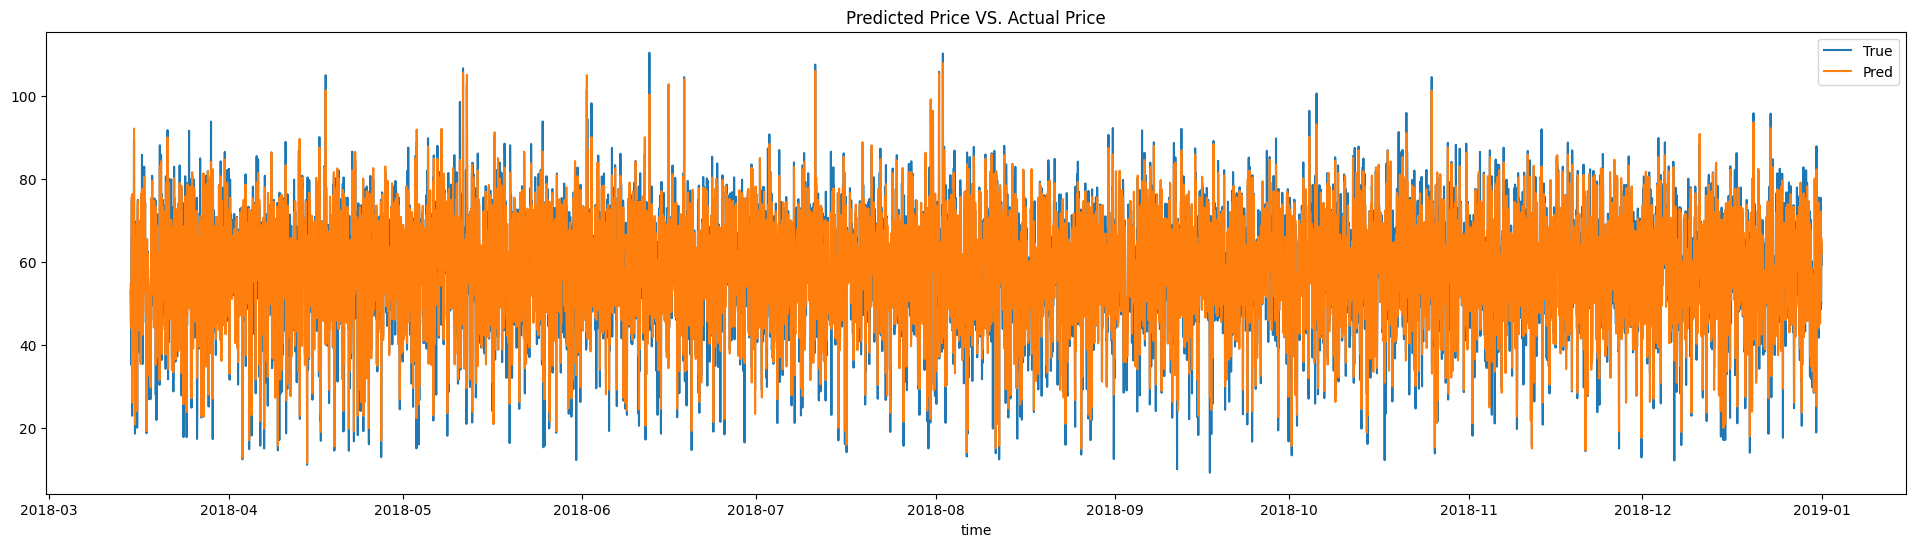

In [107]:
# sns plot for same purpose
plt.figure(figsize=(24,6))
ax = plt.subplot(111)
sns.lineplot(x=df_original['time'].loc[(len(X)-num_samples_test): len(X)], y=y_test, label='True', ax=ax)
sns.lineplot(x=df_original['time'].loc[(len(X)-num_samples_test): len(X)], y=y_pred, label='Pred', ax=ax)
plt.title("Predicted Price VS. Actual Price")
plt.show()

# Feature Importance

In [121]:
# Print feature importance for random forest regressor
feature_importance = rf_model.feature_importances_
feature_names = df_encoded.columns[:-1]
# Create a dictionary to store feature names and their corresponding importance scores
if feature_names is not None:
    feature_importance_dict = dict(zip(feature_names, feature_importance))
else:
    # If feature names are not available, use generic names like f0, f1, f2, ...
    feature_importance_dict = dict(zip(range(len(feature_importance)), feature_importance))

# Sort the feature importance dictionary in descending order of importance scores
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Print the sorted feature importance
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

generation fossil gas: 0.21688017194359532
year: 0.11268929484693274
generation fossil hard coal: 0.10273837279854059
hour: 0.059703322671616314
wind_speed: 0.03907892573374053
temp_max: 0.0232116778378461
total load forecast: 0.022648729755462376
month_December: 0.02208467287662645
month_October: 0.02183411076114076
generation hydro water reservoir: 0.021583068165458356
generation waste: 0.02106106557099825
generation hydro run-of-river and poundage: 0.01968730050673819
month_January: 0.01930086097868473
generation nuclear: 0.018955149092078252
month_November: 0.01835660469097915
month_April: 0.017088352899679228
total load actual: 0.016948445242360166
pressure: 0.016737911526934438
month_March: 0.015544592893813323
temp_min: 0.014833952819747604
temp: 0.014433676644352649
generation biomass: 0.013939010640570626
generation wind onshore: 0.01380925392730623
generation hydro pumped storage consumption: 0.013360388931020505
generation other renewable: 0.013154253778033647
month_Septembe

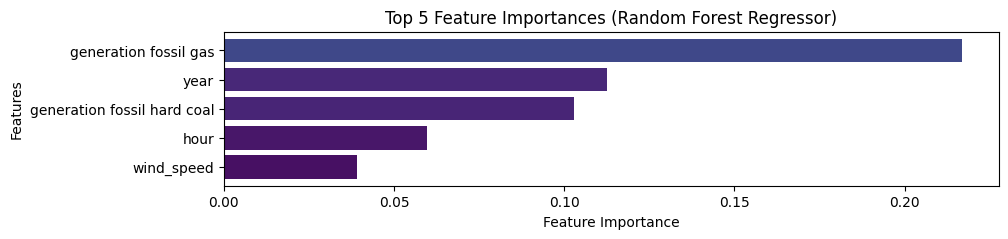

In [139]:
# Plot the top 5 features
top_features = [feature_names[idx] for idx in sorted_indices[:5]][::-1]
top_importances = [feature_importance[idx] for idx in sorted_indices[:5]][::-1]

plt.figure(figsize=(10, 2))
plt.barh(range(len(top_features)), top_importances, color=plt.cm.viridis(top_importances))
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances (Random Forest Regressor)')
plt.show()

# R2 score
R2 = 1 - (SSR / SST)

where:
- SSR (Sum of Squared Residuals) is the sum of the squared differences between the predicted values and the actual values (residuals).
- SST (Total Sum of Squares) is the sum of the squared differences between the actual values and the mean of the actual values (total variance).

Problems with Sensitivity to number of features.
- Inclusion of Irrelevant Features: When additional irrelevant features are added to the model, the R2 score may increase. Even though these features do not have any meaningful relationship with the target variable, they can still introduce noise and overfitting in the model. As a result, the model may appear to have a better fit to the training data, leading to a higher R2 score. However, this increase in R2 does not necessarily indicate improved prediction performance on new, unseen data.

- Curse of Dimensionality: As the number of features increases, the model becomes more complex. This complexity can lead to overfitting, where the model memorizes the noise and idiosyncrasies of the training data rather than learning the underlying patterns. As a consequence, the model's performance may degrade on new data, resulting in a lower ability to generalize.

- Multicollinearity: Multicollinearity occurs when two or more features are highly correlated, leading to redundancy in the information they provide. In the presence of multicollinearity, the R2 score can be inflated because the model may be attributing the same information to multiple correlated features. This can give a false sense of model performance and may not accurately represent the true predictive power of the individual features.

To address the issue of number of features sensitivity with R2 score evaluation, it is crucial to perform feature selection and/or feature engineering to retain only the most relevant and informative features for the model. 